In [1]:
"""
requirements -r
"""

import matplotlib.pyplot as plt
import numpy as np
from keras import layers
from keras import ops
import keras
import tensorflow as tf

In [2]:
"""
GC_VI_T_11
target model

"""

'\nGC_VI_T_11\ntarget model \n\n'

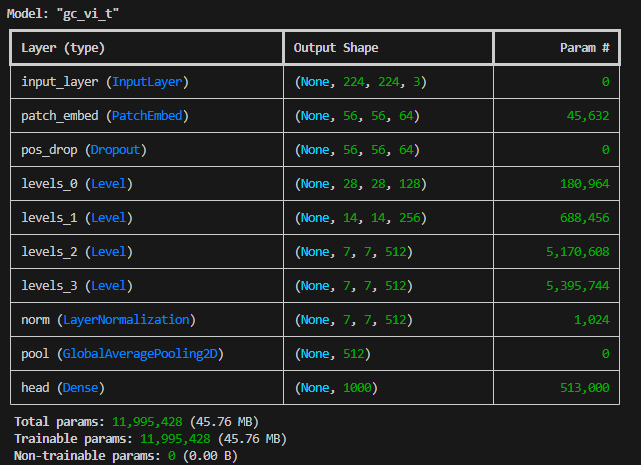

In [3]:
class DropPath(keras.layers.Layer):
    def __init__(self, rate=0.5, seed=None, **kwargs):
        super().__init__(**kwargs)
        self.rate = rate
        self.seed = seed
        self.rng = np.random.default_rng(seed)
        self.drop_mask = None
        self.last_batch_size = None
    def build(self, input_shape):
        self.drop_mask = ops.zeros((1,), dtype="float32")
        super().build(input_shape)
    def call(self, x, training=None):
        if self.rate == 0.0 or not training:
            return x
        batch_size = x.shape[0] if x.shape[0] is not None else ops.shape(x)[0]

        if batch_size != self.last_batch_size:
            drop_shape = [batch_size] + [1] * (len(x.shape) - 1)
            rand_mask = self.rng.uniform(size=drop_shape)
            self.drop_mask = ops.cast(ops.array(rand_mask > self.rate), x.dtype)
            self.last_batch_size = batch_size
        x = x / (1.0 - self.rate)
        return x * self.drop_mask

    def get_config(self):
        config = super().get_config()
        config.update({"rate": self.rate, "seed": self.seed})
        return config

In [4]:
class SqueezeAndExcitation(layers.Layer):

    def __init__(self, output_dim=None, expansion=0.25, **kwargs):
        super().__init__(**kwargs)
        self.expansion = expansion
        self.output_dim = output_dim

    def build(self, input_shape):
        inp = input_shape[-1]
        self.output_dim = self.output_dim or inp
        self.avg_pool = layers.GlobalAvgPool2D(keepdims=True, name="avg_pool")
        self.fc = [
            layers.Dense(int(inp * self.expansion), use_bias=False, name="fc_0"),
            layers.Activation("gelu", name="fc_1"),
            layers.Dense(self.output_dim, use_bias=False, name="fc_2"),
            layers.Activation("sigmoid", name="fc_3"),
        ]
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        x = self.avg_pool(inputs)
        for layer in self.fc:
            x = layer(x)
        return x * inputs

In [5]:
class ReduceSize(layers.Layer):
    def __init__(self, keepdims=False, **kwargs):
        super().__init__(**kwargs)
        self.keepdims = keepdims
    def build(self, input_shape):
        embed_dim = input_shape[-1]
        dim_out = embed_dim if self.keepdims else 2 * embed_dim
        self.pad1 = layers.ZeroPadding2D(1, name="pad1")
        self.pad2 = layers.ZeroPadding2D(1, name="pad2")
        self.conv = [
            layers.DepthwiseConv2D(
                kernel_size=3, strides=1, padding="valid", use_bias=False, name="conv_0"
            ),
            layers.Activation("gelu", name="conv_1"),
            SqueezeAndExcitation(name="conv_2"),
            layers.Conv2D(
                embed_dim,
                kernel_size=1,
                strides=1,
                padding="valid",
                use_bias=False,
                name="conv_3",
            ),
        ]
        self.reduction = layers.Conv2D(
            dim_out,
            kernel_size=3,
            strides=2,
            padding="valid",
            use_bias=False,
            name="reduction",
        )
        self.norm1 = layers.LayerNormalization(
            -1, 1e-05, name="norm1"
        )
        self.norm2 = layers.LayerNormalization(-1, 1e-05, name="norm2")

    def call(self, inputs, **kwargs):
        x = self.norm1(inputs)
        xr = self.pad1(x)
        for layer in self.conv:
            xr = layer(xr)
        x = x + xr
        x = self.pad2(x)
        x = self.reduction(x)
        x = self.norm2(x)
        return x

In [6]:
class MLP(layers.Layer):
    def __init__(
        self,
        hidden_features=None,
        out_features=None,
        activation="gelu",
        dropout=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.hidden_features = hidden_features
        self.out_features = out_features
        self.activation = activation
        self.dropout = dropout
    def build(self, input_shape):
        self.in_features = input_shape[-1]
        self.hidden_features = self.hidden_features or self.in_features
        self.out_features = self.out_features or self.in_features
        self.fc1 = layers.Dense(self.hidden_features, name="fc1")
        self.act = layers.Activation(self.activation, name="act")
        self.fc2 = layers.Dense(self.out_features, name="fc2")
        self.drop1 = layers.Dropout(self.dropout, name="drop1")
        self.drop2 = layers.Dropout(self.dropout, name="drop2")
    def call(self, inputs, **kwargs):
        x = self.fc1(inputs)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x

In [7]:
class PatchEmbed(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
    def build(self, input_shape):
        self.pad = layers.ZeroPadding2D(1, name="pad")
        self.proj = layers.Conv2D(self.embed_dim, 3, 2, name="proj")
        self.conv_down = ReduceSize(keepdims=True, name="conv_down")
    def call(self, inputs, **kwargs):
        x = self.pad(inputs)
        x = self.proj(x)
        x = self.conv_down(x)
        return x

In [8]:
class FeatureExtraction(layers.Layer):
    def __init__(self, keepdims=False, **kwargs):
        super().__init__(**kwargs)
        self.keepdims = keepdims
    def build(self, input_shape):
        embed_dim = input_shape[-1]
        self.pad1 = layers.ZeroPadding2D(1, name="pad1")
        self.pad2 = layers.ZeroPadding2D(1, name="pad2")
        self.conv = [
            layers.DepthwiseConv2D(3, 1, use_bias=False, name="conv_0"),
            layers.Activation("gelu", name="conv_1"),
            SqueezeAndExcitation(name="conv_2"),
            layers.Conv2D(embed_dim, 1, 1, use_bias=False, name="conv_3"),
        ]
        if not self.keepdims:
            self.pool = layers.MaxPool2D(3, 2, name="pool")
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        x = inputs
        xr = self.pad1(x)
        for layer in self.conv:
            xr = layer(xr)
        x = x + xr
        if not self.keepdims:
            x = self.pool(self.pad2(x))
        return x

In [9]:
class GlobalQueryGenerator(layers.Layer):
    def __init__(self, keepdims=False, **kwargs):
        super().__init__(**kwargs)
        self.keepdims = keepdims
    def build(self, input_shape):
        self.to_q_global = [
            FeatureExtraction(keepdims, name=f"to_q_global_{i}")
            for i, keepdims in enumerate(self.keepdims)
        ]
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        x = inputs
        for layer in self.to_q_global:
            x = layer(x)
        return x

In [10]:
class WindowAttention(layers.Layer):
    def __init__(
        self,
        window_size,
        num_heads,
        global_query,
        qkv_bias=True,
        qk_scale=None,
        attention_dropout=0.0,
        projection_dropout=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        window_size = (window_size, window_size)
        self.window_size = window_size
        self.num_heads = num_heads
        self.global_query = global_query
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.attention_dropout = attention_dropout
        self.projection_dropout = projection_dropout

    def build(self, input_shape):
        embed_dim = input_shape[0][-1]
        head_dim = embed_dim // self.num_heads
        self.scale = self.qk_scale or head_dim**-0.5
        self.qkv_size = 3 - int(self.global_query)
        self.qkv = layers.Dense(
            embed_dim * self.qkv_size, use_bias=self.qkv_bias, name="qkv"
        )
        self.relative_position_bias_table = self.add_weight(
            name="relative_position_bias_table",
            shape=[
                (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1),
                self.num_heads,
            ],
            initializer=keras.initializers.TruncatedNormal(stddev=0.02),
            trainable=True,
            dtype=self.dtype,
        )
        self.attn_drop = layers.Dropout(self.attention_dropout, name="attn_drop")
        self.proj = layers.Dense(embed_dim, name="proj")
        self.proj_drop = layers.Dropout(self.projection_dropout, name="proj_drop")
        self.softmax = layers.Activation("softmax", name="softmax")
        super().build(input_shape)

    def get_relative_position_index(self):
        coords_h = ops.arange(self.window_size[0])
        coords_w = ops.arange(self.window_size[1])
        coords = ops.stack(ops.meshgrid(coords_h, coords_w, indexing="ij"), axis=0)
        coords_flatten = ops.reshape(coords, [2, -1])
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = ops.transpose(relative_coords, axes=[1, 2, 0])
        relative_coords_xx = relative_coords[:, :, 0] + self.window_size[0] - 1
        relative_coords_yy = relative_coords[:, :, 1] + self.window_size[1] - 1
        relative_coords_xx = relative_coords_xx * (2 * self.window_size[1] - 1)
        relative_position_index = relative_coords_xx + relative_coords_yy
        return relative_position_index

    def call(self, inputs, **kwargs):
        if self.global_query:
            inputs, q_global = inputs
            B = ops.shape(q_global)[0]
        else:
            inputs = inputs[0]
        B_, N, C = ops.shape(inputs)
        qkv = self.qkv(inputs)
        qkv = ops.reshape(
            qkv, [B_, N, self.qkv_size, self.num_heads, C // self.num_heads]
        )
        qkv = ops.transpose(qkv, [2, 0, 3, 1, 4])
        if self.global_query:
            k, v = ops.split(
                qkv, indices_or_sections=2, axis=0
            )
            q_global = ops.repeat(
                q_global, repeats=B_ // B, axis=0
            )
            q = ops.reshape(q_global, [B_, N, self.num_heads, C // self.num_heads])
            q = ops.transpose(q, axes=[0, 2, 1, 3])
        else:
            q, k, v = ops.split(qkv, indices_or_sections=3, axis=0)
            q = ops.squeeze(q, axis=0)

        k = ops.squeeze(k, axis=0)
        v = ops.squeeze(v, axis=0)

        q = q * self.scale
        attn = q @ ops.transpose(k, axes=[0, 1, 3, 2])
        relative_position_bias = ops.take(
            self.relative_position_bias_table,
            ops.reshape(self.get_relative_position_index(), [-1]),
        )
        relative_position_bias = ops.reshape(
            relative_position_bias,
            [
                self.window_size[0] * self.window_size[1],
                self.window_size[0] * self.window_size[1],
                -1,
            ],
        )
        relative_position_bias = ops.transpose(relative_position_bias, axes=[2, 0, 1])
        attn = attn + relative_position_bias[None,]
        attn = self.softmax(attn)
        attn = self.attn_drop(attn)

        x = ops.transpose((attn @ v), axes=[0, 2, 1, 3])
        x = ops.reshape(x, [B_, N, C])
        x = self.proj_drop(self.proj(x))
        return x

In [11]:
class Block(layers.Layer):
    def __init__(
        self,
        window_size,
        num_heads,
        global_query,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        dropout=0.0,
        attention_dropout=0.0,
        path_drop=0.0,
        activation="gelu",
        layer_scale=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.window_size = window_size
        self.num_heads = num_heads
        self.global_query = global_query
        self.mlp_ratio = mlp_ratio
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.dropout = dropout
        self.attention_dropout = attention_dropout
        self.path_drop = path_drop
        self.activation = activation
        self.layer_scale = layer_scale

    def build(self, input_shape):
        B, H, W, C = input_shape[0]
        self.norm1 = layers.LayerNormalization(-1, 1e-05, name="norm1")
        self.attn = WindowAttention(
            window_size=self.window_size,
            num_heads=self.num_heads,
            global_query=self.global_query,
            qkv_bias=self.qkv_bias,
            qk_scale=self.qk_scale,
            attention_dropout=self.attention_dropout,
            projection_dropout=self.dropout,
            name="attn",
        )
        self.drop_path1 = DropPath(self.path_drop)
        self.drop_path2 = DropPath(self.path_drop)
        self.norm2 = layers.LayerNormalization(-1, 1e-05, name="norm2")
        self.mlp = MLP(
            hidden_features=int(C * self.mlp_ratio),
            dropout=self.dropout,
            activation=self.activation,
            name="mlp",
        )
        if self.layer_scale is not None:
            self.gamma1 = self.add_weight(
                name="gamma1",
                shape=[C],
                initializer=keras.initializers.Constant(self.layer_scale),
                trainable=True,
                dtype=self.dtype,
            )
            self.gamma2 = self.add_weight(
                name="gamma2",
                shape=[C],
                initializer=keras.initializers.Constant(self.layer_scale),
                trainable=True,
                dtype=self.dtype,
            )
        else:
            self.gamma1 = 1.0
            self.gamma2 = 1.0
        self.num_windows = int(H // self.window_size) * int(W // self.window_size)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        if self.global_query:
            inputs, q_global = inputs
        else:
            inputs = inputs[0]
        B, H, W, C = ops.shape(inputs)
        x = self.norm1(inputs)

        x = self.window_partition(x, self.window_size)

        x = ops.reshape(x, [-1, self.window_size * self.window_size, C])

        if self.global_query:
            x = self.attn([x, q_global])
        else:
            x = self.attn([x])

        x = self.window_reverse(x, self.window_size, H, W, C)

        x = inputs + self.drop_path1(x * self.gamma1)
        x = x + self.drop_path2(self.gamma2 * self.mlp(self.norm2(x)))
        return x

    def window_partition(self, x, window_size):

        B, H, W, C = ops.shape(x)
        x = ops.reshape(
            x,
            [
                -1,
                H // window_size,
                window_size,
                W // window_size,
                window_size,
                C,
            ],
        )
        x = ops.transpose(x, axes=[0, 1, 3, 2, 4, 5])
        windows = ops.reshape(x, [-1, window_size, window_size, C])
        return windows

    def window_reverse(self, windows, window_size, H, W, C):

        x = ops.reshape(
            windows,
            [
                -1,
                H // window_size,
                W // window_size,
                window_size,
                window_size,
                C,
            ],
        )
        x = ops.transpose(x, axes=[0, 1, 3, 2, 4, 5])
        x = ops.reshape(x, [-1, H, W, C])
        return x

In [12]:
class Level(layers.Layer):
    def __init__(
        self,
        depth,
        num_heads,
        window_size,
        keepdims,
        downsample=True,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        dropout=0.0,
        attention_dropout=0.0,
        path_drop=0.0,
        layer_scale=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.depth = depth
        self.num_heads = num_heads
        self.window_size = window_size
        self.keepdims = keepdims
        self.downsample = downsample
        self.mlp_ratio = mlp_ratio
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.dropout = dropout
        self.attention_dropout = attention_dropout
        self.path_drop = path_drop
        self.layer_scale = layer_scale

    def build(self, input_shape):
        path_drop = (
            [self.path_drop] * self.depth
            if not isinstance(self.path_drop, list)
            else self.path_drop
        )
        self.blocks = [
            Block(
                window_size=self.window_size,
                num_heads=self.num_heads,
                global_query=bool(i % 2),
                mlp_ratio=self.mlp_ratio,
                qkv_bias=self.qkv_bias,
                qk_scale=self.qk_scale,
                dropout=self.dropout,
                attention_dropout=self.attention_dropout,
                path_drop=path_drop[i],
                layer_scale=self.layer_scale,
                name=f"blocks_{i}",
            )
            for i in range(self.depth)
        ]
        self.down = ReduceSize(keepdims=False, name="downsample")
        self.q_global_gen = GlobalQueryGenerator(self.keepdims, name="q_global_gen")
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        x = inputs
        q_global = self.q_global_gen(x)
        for i, blk in enumerate(self.blocks):
            if i % 2:
                x = blk([x, q_global])
            else:
                x = blk([x])
        if self.downsample:
            x = self.down(x)
        return x

In [13]:
class GCViT(keras.Model):
    def __init__(
        self,
        window_size,
        embed_dim,
        depths,
        num_heads,
        drop_rate=0.0,
        mlp_ratio=3.0,
        qkv_bias=True,
        qk_scale=None,
        attention_dropout=0.0,
        path_drop=0.1,
        layer_scale=None,
        num_classes=1000,
        head_activation="softmax",
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.window_size = window_size
        self.embed_dim = embed_dim
        self.depths = depths
        self.num_heads = num_heads
        self.drop_rate = drop_rate
        self.mlp_ratio = mlp_ratio
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.attention_dropout = attention_dropout
        self.path_drop = path_drop
        self.layer_scale = layer_scale
        self.num_classes = num_classes
        self.head_activation = head_activation

        self.patch_embed = PatchEmbed(embed_dim=embed_dim, name="patch_embed")
        self.pos_drop = layers.Dropout(drop_rate, name="pos_drop")
        path_drops = np.linspace(0.0, path_drop, sum(depths))
        keepdims = [(0, 0, 0), (0, 0), (1,), (1,)]
        self.levels = []
        for i in range(len(depths)):
            path_drop = path_drops[sum(depths[:i]) : sum(depths[: i + 1])].tolist()
            level = Level(
                depth=depths[i],
                num_heads=num_heads[i],
                window_size=window_size[i],
                keepdims=keepdims[i],
                downsample=(i < len(depths) - 1),
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                dropout=drop_rate,
                attention_dropout=attention_dropout,
                path_drop=path_drop,
                layer_scale=layer_scale,
                name=f"levels_{i}",
            )
            self.levels.append(level)
        self.norm = layers.LayerNormalization(axis=-1, epsilon=1e-05, name="norm")
        self.pool = layers.GlobalAvgPool2D(name="pool")
        self.head = layers.Dense(num_classes, name="head", activation=head_activation)

    def build(self, input_shape):
        super().build(input_shape)
        self.built = True

    def call(self, inputs, **kwargs):
        x = self.patch_embed(inputs)
        x = self.pos_drop(x)
        for level in self.levels:
            x = level(x)
        x = self.norm(x)
        x = self.pool(x)
        x = self.head(x)
        return x

    def build_graph(self, input_shape=(224, 224, 3)):

        x = keras.Input(shape=input_shape)
        return keras.Model(inputs=[x], outputs=self.call(x), name=self.name)

    def summary(self, input_shape=(224, 224, 3)):
        return self.build_graph(input_shape).summary()

In [14]:
from google.colab import files
uploaded = files.upload()

Saving gcvitxxtiny.keras to gcvitxxtiny.keras


In [15]:
ckpt_path = r"/content/gcvitxxtiny.keras"
config = {
    "window_size": (7, 7, 14, 7),
    "embed_dim": 64,
    "depths": (2, 2, 6, 2),
    "num_heads": (2, 4, 8, 16),
    "mlp_ratio": 3.0,
    "path_drop": 0.2,
}

model = GCViT(**config)
inp = ops.array(np.random.uniform(size=(1, 224, 224, 3)))
out = model(inp)

ckpt_path = r"/content/gcvitxxtiny.keras"
model.load_weights(ckpt_path)


model.summary((224, 224, 3))

Model: "gc_vi_t"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_embed (PatchEmbed)        │ (None, 56, 56, 64)     │        45,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pos_drop (Dropout)              │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ levels_0 (Level)                │ (None, 28, 28, 128)    │       180,964 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ levels_1 (Level)                │ (None, 14, 14, 256)    │       688,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ levels_2 (Level)                │ (None, 7, 7, 512)      │     5,170,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ levels_3 (Level)                │ (None, 7, 7, 512)      │     5,395,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm (LayerNormalization)       │ (None, 7, 7, 512)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool (GlobalAveragePooling2D)   │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head (Dense)                    │ (None, 1000)           │       513,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,995,428 (45.76 MB)

 Trainable params: 11,995,428 (45.76 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5
CLASSES = ['Moon_jellyfish', 'barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish', 'mauve_stinger_jellyfish']
MEAN = 255 * np.array([0.485, 0.456, 0.406], dtype="float32")
STD = 255 * np.array([0.229, 0.224, 0.225], dtype="float32")
AUTO = tf.data.AUTOTUNE

data_dir = r"/content/drive/MyDrive/concave"

In [26]:
full_dataset = keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    class_names=CLASSES,
    color_mode="rgb",
    batch_size=None,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42,
)
dataset_size = full_dataset.cardinality().numpy()
train_size = int(0.9 * dataset_size)
val_size = dataset_size - train_size

train_dataset = full_dataset.take(train_size)
val_dataset = full_dataset.skip(train_size)

def make_dataset(dataset: tf.data.Dataset, train: bool, image_size: int = IMAGE_SIZE):
    def preprocess(image, label):
        if train:
            if tf.random.uniform(shape=[]) > 0.5:
                image = tf.image.flip_left_right(image)
        image = tf.image.resize(image, size=image_size, method="bicubic")
        image = (image - MEAN) / STD
        return image, label

    if train:
        dataset = dataset.shuffle(BATCH_SIZE * 10)

    return dataset.map(preprocess, AUTO).batch(BATCH_SIZE).prefetch(AUTO)

train_dataset = make_dataset(train_dataset, train=True)
val_dataset = make_dataset(val_dataset, train=False)

model = GCViT(**config, num_classes=6)
inp = ops.array(np.random.uniform(size=(1, 224, 224, 3)))
out = model(inp)

Found 899 files belonging to 6 classes.


In [27]:
model.load_weights(ckpt_path, skip_mismatch=True)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:629: UserWarning: A total of 1 objects could not be loaded. Example error message for object <Dense name=head, built=True>:

Layer 'head' expected 2 variables, but received 0 variables during loading. Expected: ['kernel', 'bias']

List of objects that could not be loaded:
[<Dense name=head, built=True>]
  warnings.warn(msg)


In [28]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

In [29]:
history = model.fit(
    train_dataset, validation_data=val_dataset, epochs=EPOCHS, verbose=1
)

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.2787 - loss: 1.7214 - val_accuracy: 0.7444 - val_loss: 0.7419
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 52s 435ms/step - accuracy: 0.6939 - loss: 0.8264 - val_accuracy: 0.7667 - val_loss: 0.7094
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 472ms/step - accuracy: 0.8239 - loss: 0.5657 - val_accuracy: 0.9333 - val_loss: 0.2130
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 427ms/step - accuracy: 0.8759 - loss: 0.4040 - val_accuracy: 0.8556 - val_loss: 0.3860
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 436ms/step - accuracy: 0.9123 - loss: 0.2778 - val_accuracy: 0.9778 - val_loss: 0.0575


In [30]:
print("Accuracy of the model:", history.history["accuracy"][-1])
print("Validation Accuracy of the model:", history.history["val_accuracy"][-1])

Accuracy of the model: 0.9159455895423889
Validation Accuracy of the model: 0.9777777791023254


In [31]:
from sklearn.metrics import classification_report
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
print(classification_report(y_true, y_pred, target_names=CLASSES))

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
                         precision    recall  f1-score   support

         Moon_jellyfish       0.92      0.92      0.92        13
       barrel_jellyfish       0.88      1.00      0.94        15
         blue_jellyfish       0.92      0.85      0.88        13
      compass_jellyfish       1.00      0.94      0.97        17
   lions_mane_jellyfish       1.00      1.00      1.00        13
mauve_stinger_jellyfish       1.00      1.00      1.00        19

               accuracy                           0.96        90
              macro avg       0.95      0.95      0.95        90
           weighted avg       0.96      0.96      0.96        90

